# Baseline model

- Value of Product: Improve health of general public

- Prediction: PM2.5 (particle concentration per cubic meter)

- Hypothesis: Temperature and windspeed are the most important features.

- Model: Linear regression with features ['temp', 'wind_spd', 'wind_dir']

- Metric: RMSE (as recommended by Zindi) = 43.04

In [88]:
# Data manipulation
import pandas as pd
import numpy as np
import missingno as msno

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [89]:
rs = 42

In [90]:
df_main = pd.read_csv('../data/train_daily_mean.csv')

In [91]:
df_main.isna().sum()

ID                 0
day                0
temp            1314
precip          1405
rel_humidity    1277
wind_dir        1520
wind_spd        1520
atmos_press     1276
dtype: int64

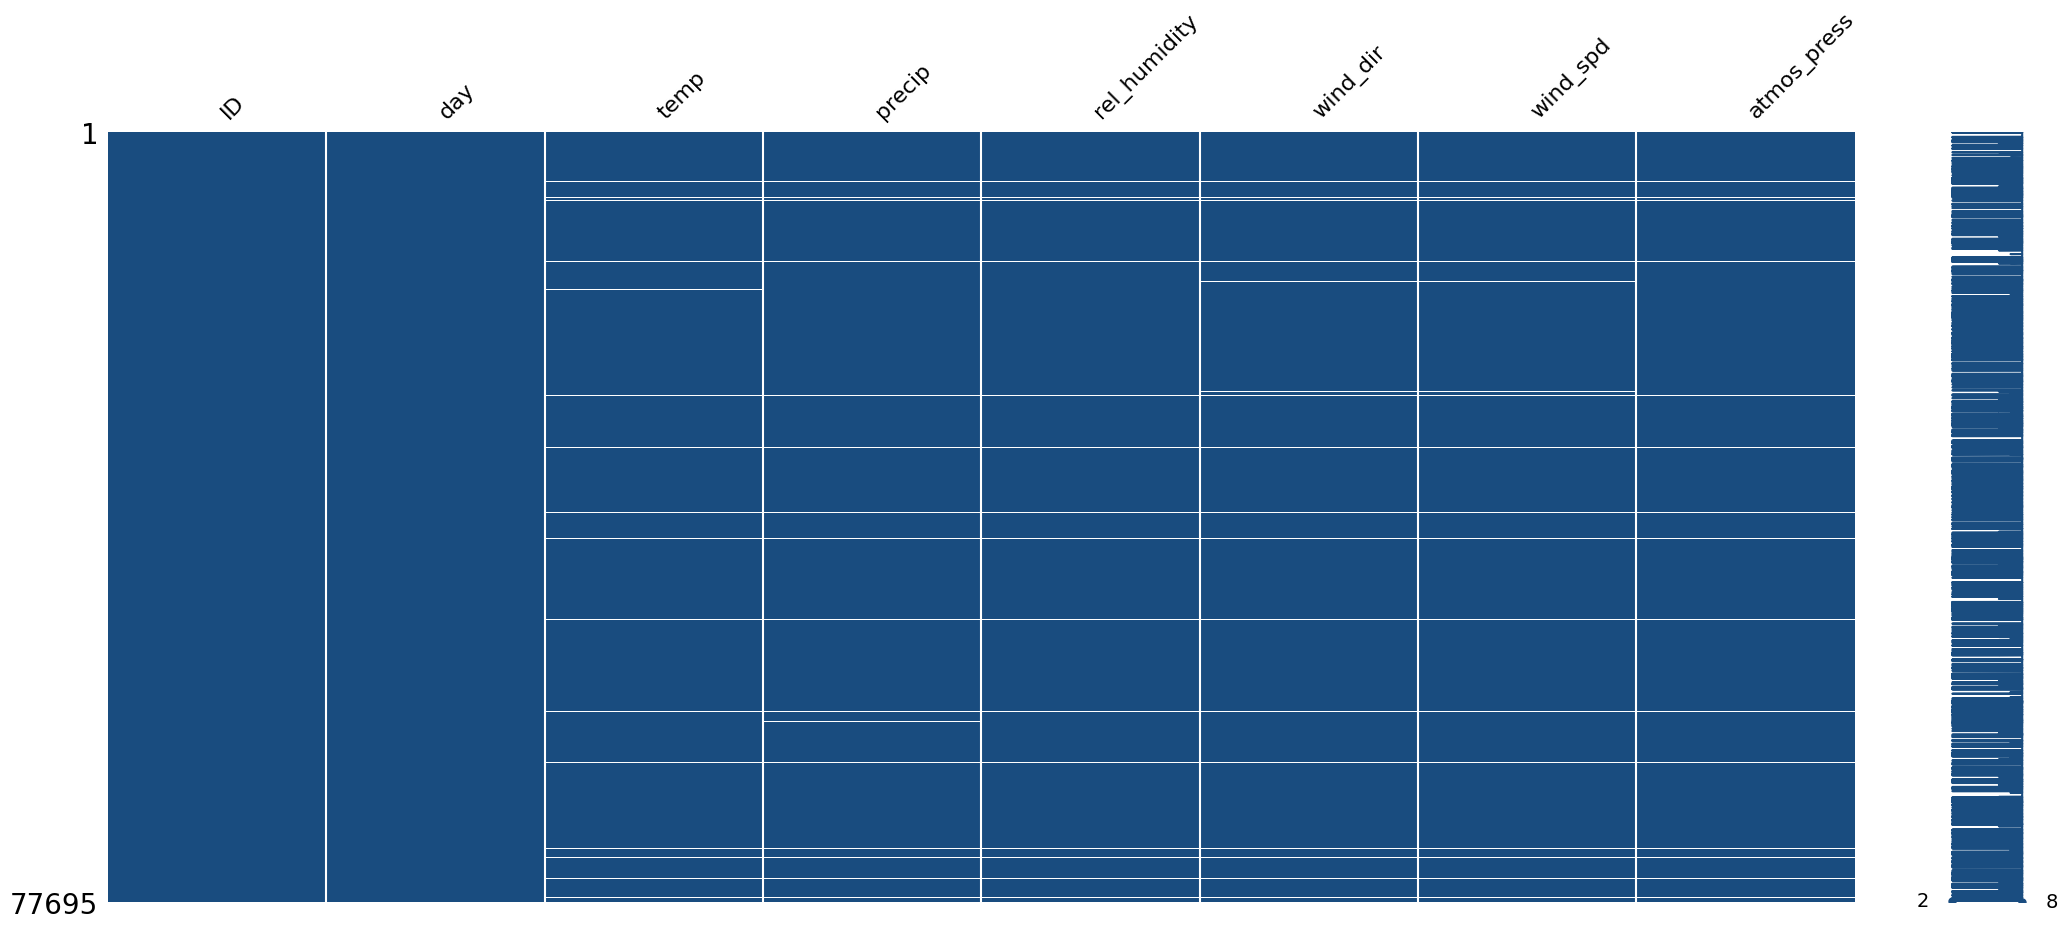

In [92]:
msno.matrix(df_main, color=(0.1, 0.3, 0.5));

In [93]:
df_clean = df_main.dropna(axis=0)

In [94]:
rows_dropped_percent = np.round(100 - (df_clean.shape[0] / df_main.shape[0]) * 100, 2)
print(f"Dropped {rows_dropped_percent}% of rows.")

Dropped 2.17% of rows.


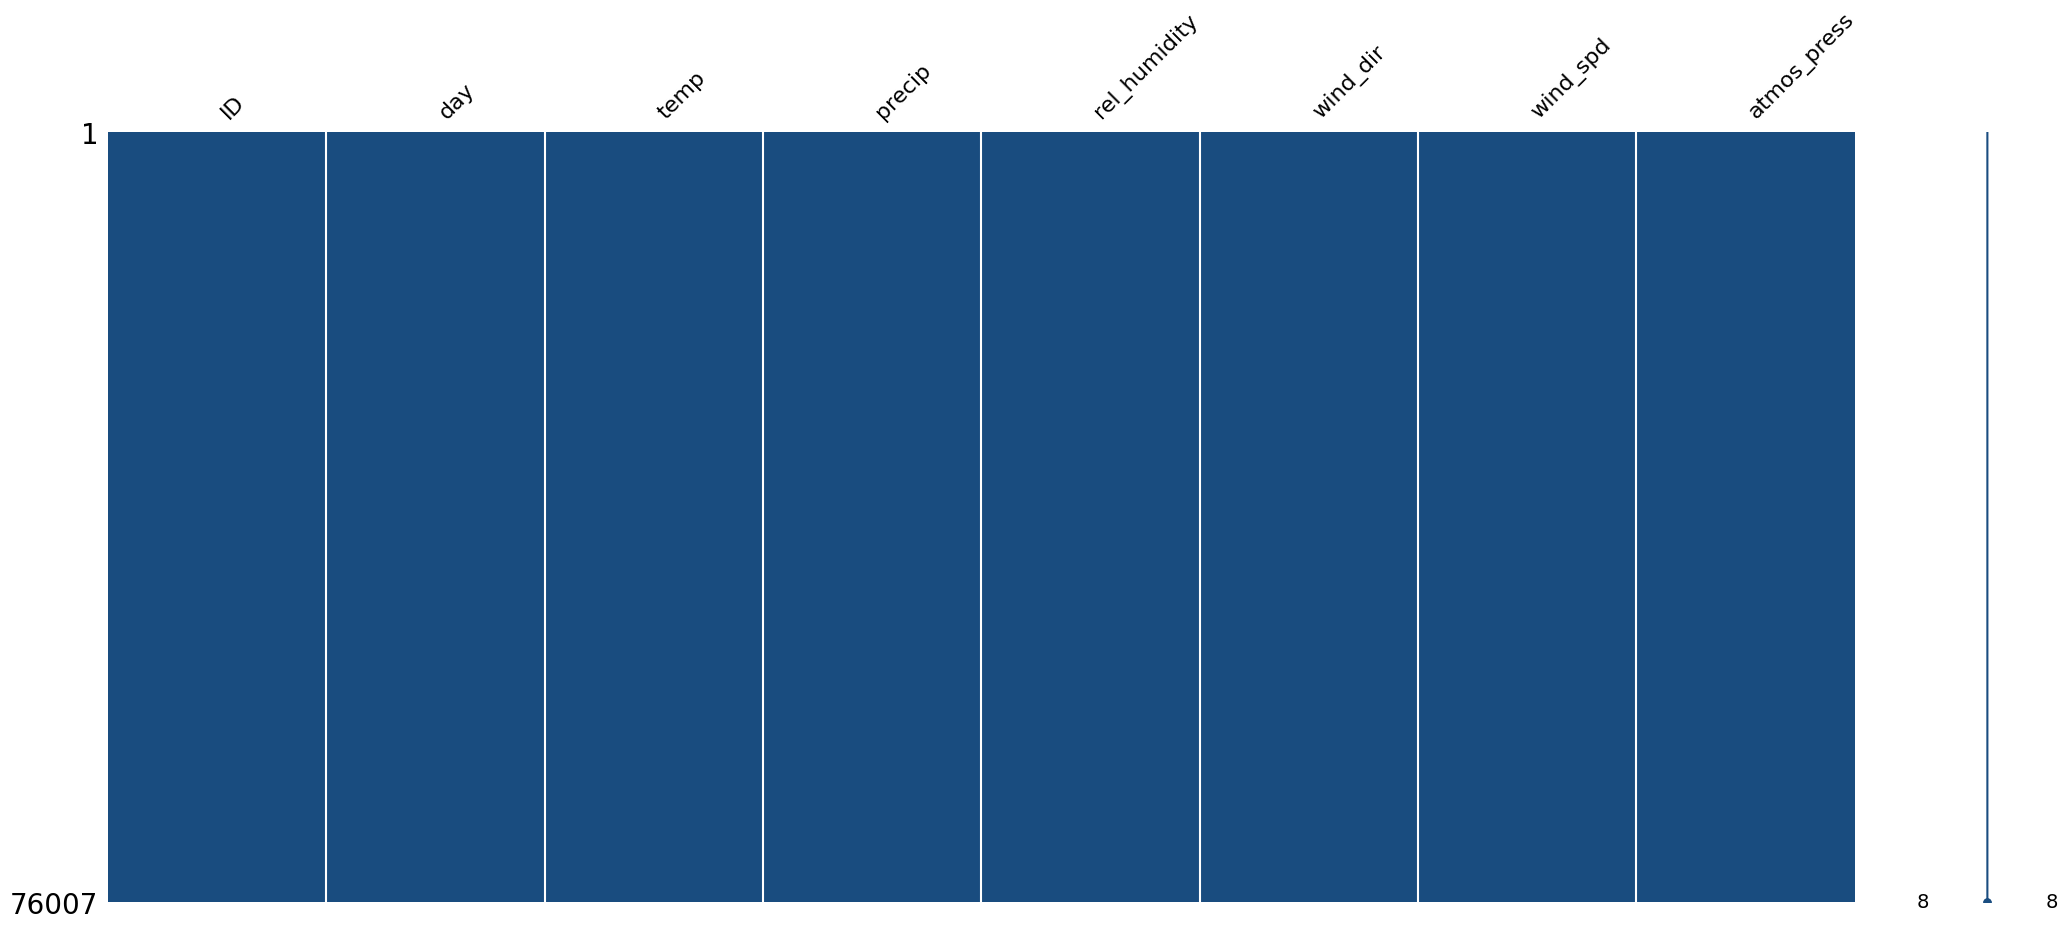

In [95]:
msno.matrix(df_clean, color=(0.1, 0.3, 0.5));

In [96]:
# check for incomplete 5-day observation sets
labels = df_clean.groupby('ID')['day'].count() == 5
labels = labels.reset_index()

labels

,ID,day
0,ID_train_0,False
1,ID_train_1,True
2,ID_train_10,False
3,ID_train_100,True
4,ID_train_1000,False
...,...,...
15534,ID_train_9995,True
15535,ID_train_9996,True
15536,ID_train_9997,True
15537,ID_train_9998,True


In [97]:
df_clean.info()
labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76007 entries, 4 to 77694
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            76007 non-null  object 
 1   day           76007 non-null  float64
 2   temp          76007 non-null  float64
 3   precip        76007 non-null  float64
 4   rel_humidity  76007 non-null  float64
 5   wind_dir      76007 non-null  float64
 6   wind_spd      76007 non-null  float64
 7   atmos_press   76007 non-null  float64
dtypes: float64(7), object(1)
memory usage: 5.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15539 entries, 0 to 15538
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      15539 non-null  object
 1   day     15539 non-null  bool  
dtypes: bool(1), object(1)
memory usage: 136.7+ KB


In [98]:
# remove non-complete observation sets
df_clean = df_clean.merge(labels, on='ID')
df_clean = df_clean[df_clean['day_y'] == True]
df_clean

rows_dropped_percent = 100 - (df_clean.shape[0] / df_main.shape[0]) * 100
print(f"Dropped {rows_dropped_percent}% of rows.")

Dropped 5.695347190938932% of rows.


In [99]:
# readding target
targets = pd.read_csv('../data/Train.csv', usecols=['ID', 'target'])
targets

,ID,target
0,ID_train_0,45.126304
1,ID_train_1,79.131702
2,ID_train_10,32.661304
3,ID_train_100,53.850238
4,ID_train_1000,177.418750
...,...,...
15534,ID_train_9995,44.850286
15535,ID_train_9996,24.330455
15536,ID_train_9997,38.972128
15537,ID_train_9998,41.720952


In [100]:
df_clean = df_clean.merge(targets, on='ID', how='inner')

## Baseline model: daily averages

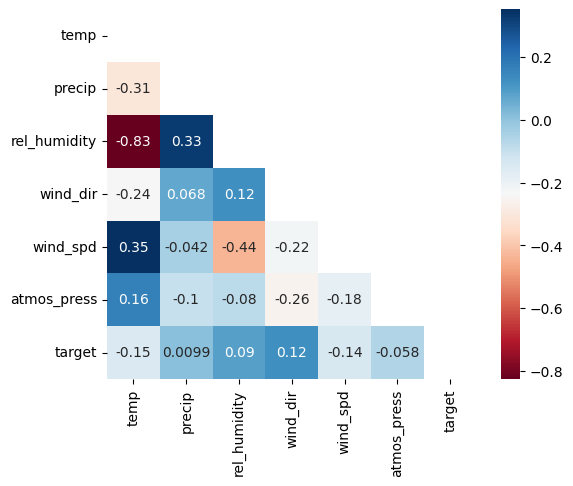

In [101]:
# check correlation matrix for contributions
corrs = df_clean.iloc[:, 2:].drop('day_y', axis=1).corr()
mask = np.zeros_like(corrs)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corrs, mask=mask, cmap=plt.colormaps.get('RdBu'), annot=True, square=True);

In [102]:
# All features: ['ID', 'day_x', 'temp', 'precip', 'rel_humidity', 'wind_dir', 'wind_spd','atmos_press', 'day_y', 'target']
features = ['temp', 'precip', 'rel_humidity', 'wind_dir', 'wind_spd','atmos_press', 'target']
df_baseline = df_clean.groupby('ID')[features].mean()
df_baseline = df_baseline.reset_index().drop('ID', axis=1)
df_baseline.head(1)

,temp,precip,rel_humidity,wind_dir,wind_spd,atmos_press,target
0,24.679736,0.00701,0.757967,177.089494,0.900148,90.430503,79.131702


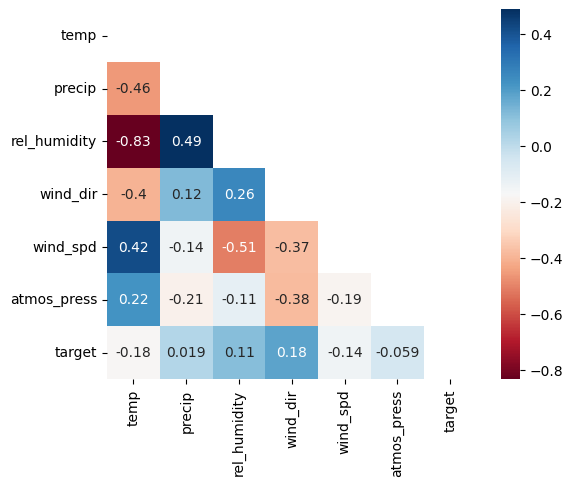

In [103]:
# check correlation matrix for contributions after averaging 5 day intervals
corrs = df_baseline.corr()
mask = np.zeros_like(corrs)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corrs, mask=mask, cmap=plt.colormaps.get('RdBu'), annot=True, square=True);

In [104]:
# reducing features
df_baseline = df_baseline[['temp', 'wind_dir', 'wind_spd', 'rel_humidity', 'target']]

In [105]:
y = df_baseline.pop('target')
X = df_baseline

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)

In [107]:
# scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [108]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [109]:
y_pred = lr.predict(X_test)

In [110]:
print(f"RMSE for model {lr}: {np.round(mean_squared_error(y_test, y_pred, squared=False), 2)}")

RMSE for model LinearRegression(): 43.04


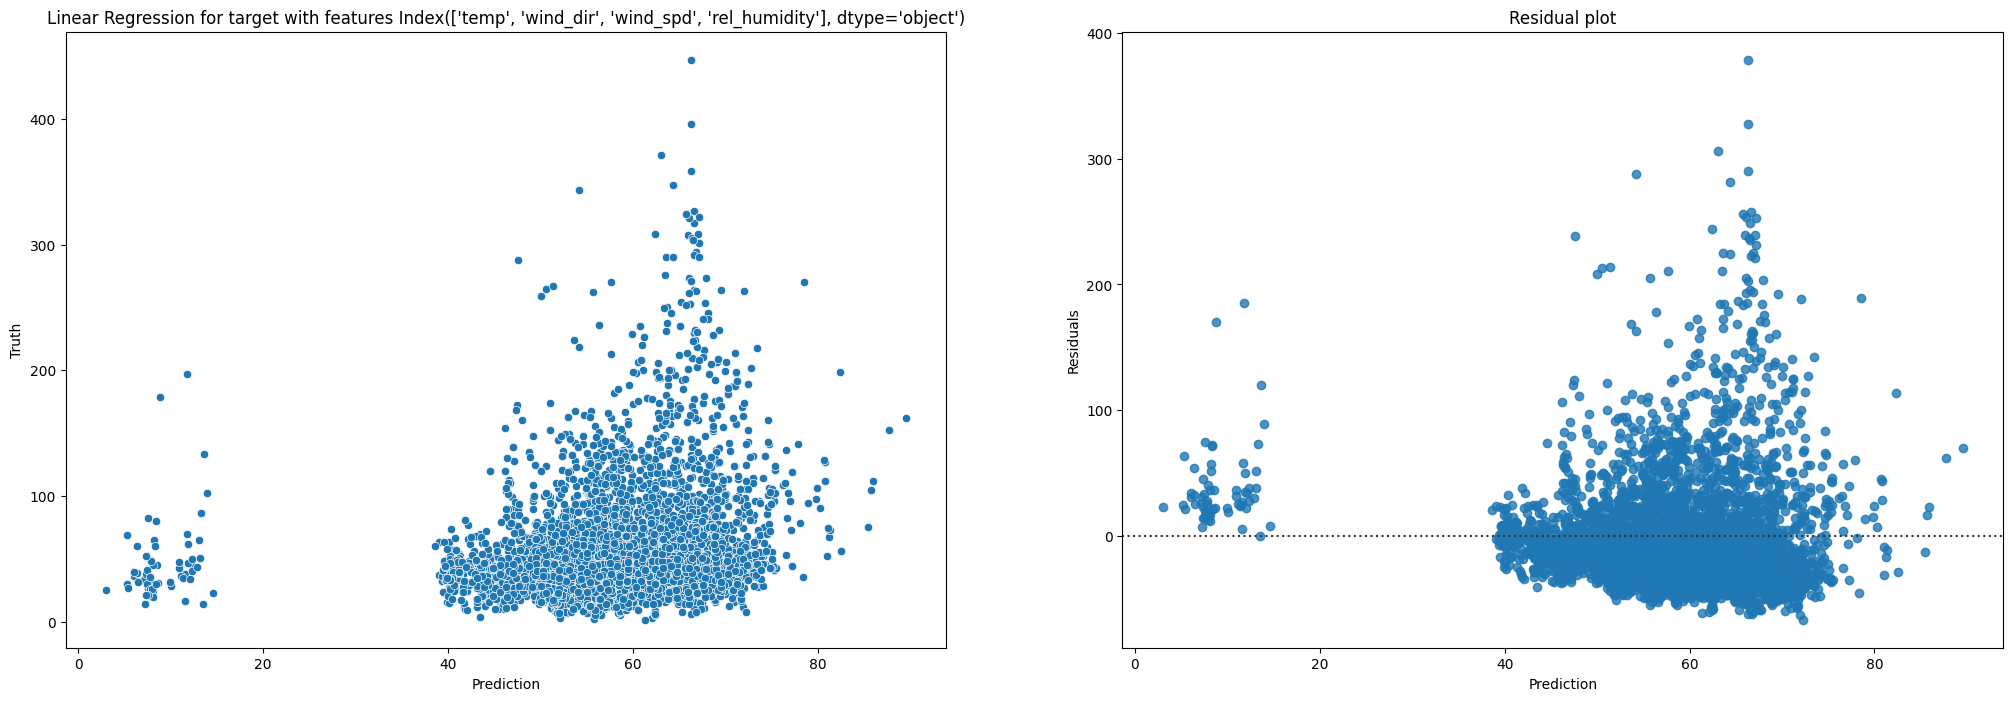

In [111]:
# plot residual distribution
fig, ax = plt.subplots(1, 2, figsize=(25, 8))

g1 = sns.scatterplot(x=y_pred, y=y_test, ax=ax[0])
g2 = sns.residplot(x=y_pred, y=y_test, ax=ax[1])

g1.set_title(f"Linear Regression for target with features {X.columns}")
g2.set_title('Residual plot')

g1.set_ylabel('Truth')
g1.set_xlabel('Prediction')
g2.set_ylabel('Residuals')
g2.set_xlabel('Prediction');

## Baseline model: hourly data

In [112]:
# reading train data in long format
df_main = pd.read_csv('../data/train_long.csv')

# drop all nan rows
df_main = df_main.dropna()

# export to csv
df_main.to_csv('../data/train_long_nonans.csv')

In [113]:
# drop index and precipitation (sensor is not working properly)
df_main = df_main.drop('Unnamed: 0', axis=1)
df_main = df_main.drop('precip', axis=1)
df_main

,ID,location,temp,rel_humidity,wind_dir,wind_spd,atmos_press,hours,day,target
105,ID_train_0,C,26.909091,0.510818,272.902752,0.800909,87.777273,105.0,5.0,45.126304
106,ID_train_0,C,27.208333,0.535417,104.565241,1.073333,87.652500,106.0,5.0,45.126304
107,ID_train_0,C,26.183333,0.614500,167.177225,1.517500,87.614167,107.0,5.0,45.126304
108,ID_train_0,C,24.700000,0.633000,165.332855,1.462500,87.637500,108.0,5.0,45.126304
109,ID_train_0,C,23.658333,0.683750,111.208901,0.516667,87.717500,109.0,5.0,45.126304
...,...,...,...,...,...,...,...,...,...,...
1880214,ID_train_9999,C,20.716667,0.910000,336.823774,0.775833,87.722500,116.0,5.0,127.983333
1880215,ID_train_9999,C,21.075000,0.871667,82.983274,0.325833,87.740833,117.0,5.0,127.983333
1880216,ID_train_9999,C,21.541667,0.785833,17.870593,0.425000,87.768333,118.0,5.0,127.983333
1880217,ID_train_9999,C,21.483333,0.736667,334.666143,0.701667,87.805833,119.0,5.0,127.983333


In [114]:
# delete where day.count != 5
labels = df_main.groupby('ID')['day'].nunique() == 5
labels = labels.reset_index()
labels

,ID,day
0,ID_train_0,False
1,ID_train_1,True
2,ID_train_10,False
3,ID_train_100,True
4,ID_train_1000,False
...,...,...
15534,ID_train_9995,True
15535,ID_train_9996,True
15536,ID_train_9997,True
15537,ID_train_9998,True


In [115]:
# remove non-complete observation sets
df_main = df_main.merge(labels, on='ID')
df_main = df_main[df_main['day_y'] == True]

In [116]:
df_main

,ID,location,temp,rel_humidity,wind_dir,wind_spd,atmos_press,hours,day_x,target,day_y
16,ID_train_1,D,22.533333,0.744583,281.664310,2.377500,90.320000,0.0,1.0,79.131702,True
17,ID_train_1,D,21.716667,0.808083,89.156293,1.126667,90.377500,1.0,1.0,79.131702,True
18,ID_train_1,D,20.833333,0.911167,81.968539,0.700833,90.440833,2.0,1.0,79.131702,True
19,ID_train_1,D,20.983333,0.916333,291.018632,0.341667,90.472500,3.0,1.0,79.131702,True
20,ID_train_1,D,20.875000,0.929750,279.391524,0.440833,90.454167,4.0,1.0,79.131702,True
...,...,...,...,...,...,...,...,...,...,...,...
1674867,ID_train_9999,C,20.716667,0.910000,336.823774,0.775833,87.722500,116.0,5.0,127.983333,True
1674868,ID_train_9999,C,21.075000,0.871667,82.983274,0.325833,87.740833,117.0,5.0,127.983333,True
1674869,ID_train_9999,C,21.541667,0.785833,17.870593,0.425000,87.768333,118.0,5.0,127.983333,True
1674870,ID_train_9999,C,21.483333,0.736667,334.666143,0.701667,87.805833,119.0,5.0,127.983333,True


In [117]:
df_main.to_csv('../data/train_hourly.csv', index=False)

In [118]:
y = df_main.pop('target')
X = df_main.iloc[:, 2:-3]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

In [119]:
print(f"RMSE for model {lr}: {np.round(mean_squared_error(y_test, y_pred, squared=False), 2)}")

RMSE for model LinearRegression(): 42.57


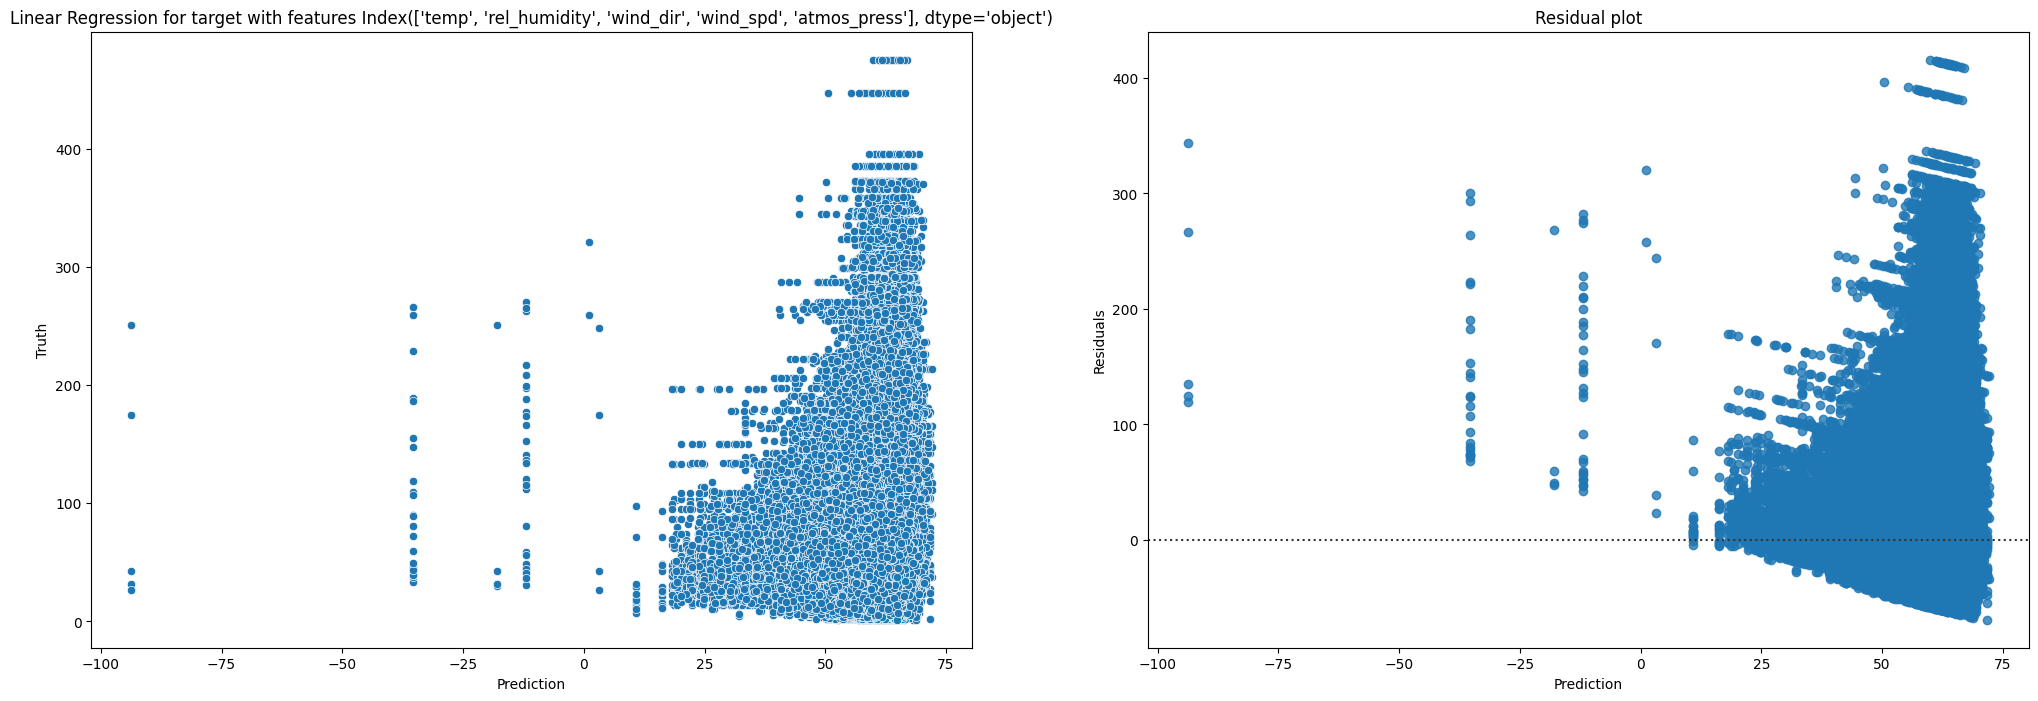

In [120]:
# plot residual distribution
fig, ax = plt.subplots(1, 2, figsize=(25, 8))

g1 = sns.scatterplot(x=y_pred, y=y_test, ax=ax[0])
g2 = sns.residplot(x=y_pred, y=y_test, ax=ax[1])

g1.set_title(f"Linear Regression for target with features {X.columns}")
g2.set_title('Residual plot')

g1.set_ylabel('Truth')
g1.set_xlabel('Prediction')
g2.set_ylabel('Residuals')
g2.set_xlabel('Prediction');